# Credit Card Fraud Detection Analysis

## Overview

This notebook implements a machine learning approach to detect credit card fraud using a dataset of anonymized credit card transactions. The goal is to build an effective model that can identify fraudulent transactions while minimizing false positives.

### Dataset Information
- **Source**: European cardholders (September 2013)
- **Total Transactions**: 284,807
- **Features**: 30 (28 PCA-transformed + Time + Amount)
- **Target**: Binary classification (0 = Normal, 1 = Fraud)
- **Class Distribution**: Highly imbalanced (0.172% fraud cases)

### Methodology
1. **Data Exploration**: Understanding data distribution and patterns
2. **Data Preprocessing**: Feature scaling and engineering
3. **Class Imbalance Handling**: SMOTE oversampling technique (creates new, synthetic examples of fraud by mixing together the real ones to improve model performance)
4. **Model Training**: Multiple algorithms comparison
5. **Model Evaluation**: Performance metrics and visualization
6. **Results Analysis**: Business insights and recommendations

---


## 1. Environment Setup

Import necessary libraries for data analysis, visualization, and machine learning.


In [14]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)

# Machine Learning
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler # for feature scaling
from sklearn.ensemble import RandomForestClassifier #learning model using multiple decision trees
from sklearn.linear_model import LogisticRegression #for binary classification problems
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Handle imbalanced data
from imblearn.over_sampling import SMOTE


## 2. Data Loading and Exploration

Load the dataset and examine its structure, missing values, and class distribution.


In [15]:
# Load the dataset
df = pd.read_csv('creditcard.csv')

# Basic dataset information
print("Dataset Shape:", df.shape)
print("\nMissing Values:", df.isnull().sum().sum())

# Display first few rows
df.head()


Dataset Shape: (284807, 31)

Missing Values: 0


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Class Distribution:
Normal transactions (0): 284,315 (99.827%)
Fraud transactions (1): 492 (0.173%)
Imbalance ratio: 1:577


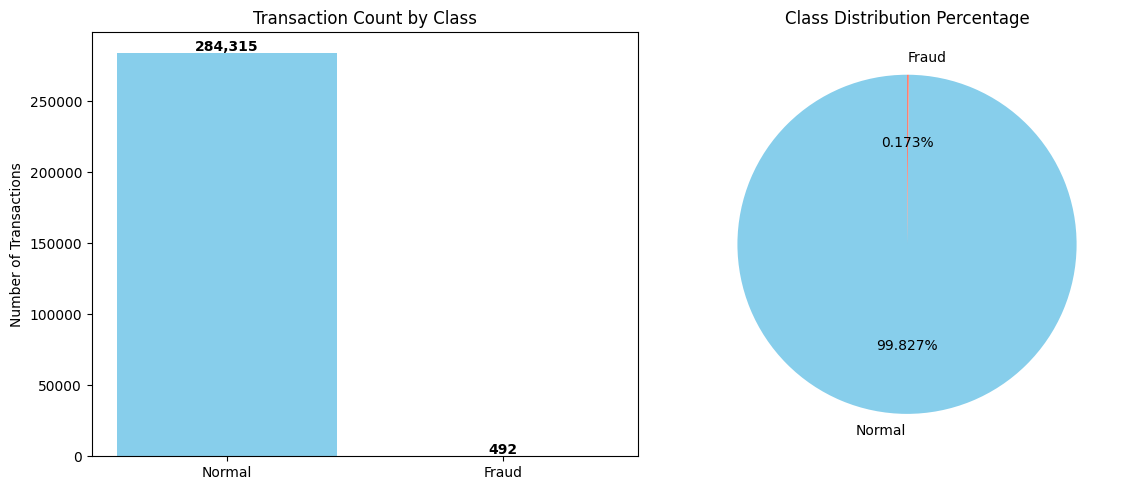

In [16]:
# Analyze class distribution
class_counts = df['Class'].value_counts()
fraud_percentage = (class_counts[1] / len(df)) * 100

print("Class Distribution:")
print(f"Normal transactions (0): {class_counts[0]:,} ({100-fraud_percentage:.3f}%)")
print(f"Fraud transactions (1): {class_counts[1]:,} ({fraud_percentage:.3f}%)")
print(f"Imbalance ratio: 1:{class_counts[0]//class_counts[1]}")

# Visualizing class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot
ax1.bar(['Normal', 'Fraud'], class_counts.values, color=['skyblue', 'salmon'])
ax1.set_title('Transaction Count by Class')
ax1.set_ylabel('Number of Transactions')
for i, v in enumerate(class_counts.values):
    ax1.text(i, v + 1000, f'{v:,}', ha='center', fontweight='bold')

# Pie chart
ax2.pie(class_counts.values, labels=['Normal', 'Fraud'], autopct='%1.3f%%', 
        colors=['skyblue', 'salmon'], startangle=90)
ax2.set_title('Class Distribution Percentage')

plt.tight_layout()
plt.show()


Transaction Amount Analysis:

Overall Amount Statistics:
count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

Amount Statistics by Class:
        count        mean  median         std  min       max
Class                                                       
0      284315   88.291022   22.00  250.105092  0.0  25691.16
1         492  122.211321    9.25  256.683288  0.0   2125.87


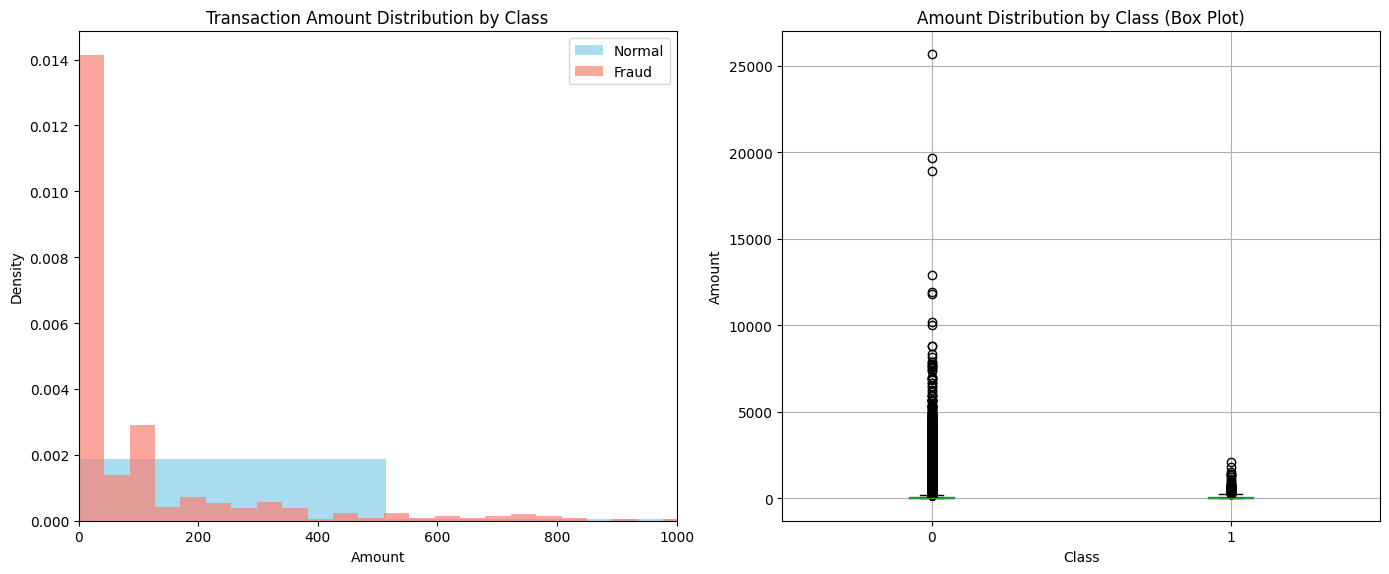

In [19]:
# Analyze transaction amounts
print("Transaction Amount Analysis:")
print("\nOverall Amount Statistics:")
print(df['Amount'].describe())

print("\nAmount Statistics by Class:")
amount_by_class = df.groupby('Class')['Amount'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
print(amount_by_class)

# Visualize amount distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Amount distribution by class
normal_amounts = df[df['Class'] == 0]['Amount']
fraud_amounts = df[df['Class'] == 1]['Amount']

ax1.hist(normal_amounts, bins=50, alpha=0.7, label='Normal', color='skyblue', density=True)
ax1.hist(fraud_amounts, bins=50, alpha=0.7, label='Fraud', color='salmon', density=True)
ax1.set_title('Transaction Amount Distribution by Class')
ax1.set_xlabel('Amount')
ax1.set_ylabel('Density')
ax1.legend()
ax1.set_xlim(0, 1000)  # Focus on smaller amounts for better visibility

# Box plot comparison
df.boxplot(column='Amount', by='Class', ax=ax2)
ax2.set_title('Amount Distribution by Class (Box Plot)')
ax2.set_xlabel('Class')
ax2.set_ylabel('Amount')
plt.suptitle('')  # Remove automatic title

plt.tight_layout()
plt.show()


These graphs compare the transaction amounts for legitimate purchases (Class 0) and fraudulent ones (Class 1).

**Distribution Plot:**

The distribution for **legitimate transactions** is heavily right-skewed, meaning most transactions are very small (clustered near $0), with a long tail of less frequent, larger transactions.

**Fraudulent activity** is proportionally more common in the low-to-medium price range (roughly 50 USD  to $500) compared to legitimate activity.  



**Box Plot:**

This highlights that the typical fraudulent transaction is actually for a smaller amount than the typical legitimate one. However, the legitimate transactions have a much wider range, including many extremely high-value purchases that are not common with fraud.

## 3. Data Preprocessing

Prepare the data for machine learning by scaling features and handling the class imbalance.


In [20]:
# Prepare features and target
X = df.drop('Class', axis=1) #transaction details
y = df['Class'] # target class

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nData Split:")
print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Training fraud rate: {y_train.mean():.4f}")
print(f"Test fraud rate: {y_test.mean():.4f}")


Feature matrix shape: (284807, 30)
Target vector shape: (284807,)

Data Split:
Training set: 227,845 samples
Test set: 56,962 samples
Training fraud rate: 0.0017
Test fraud rate: 0.0017


---
The output shows the extreme **class imbalance**. Only **0.17%** of transactions are fraudulent. This is the biggest challenge in fraud detection.

A naive model could simply predict "not fraud" for every single transaction and still be **99.83% accurate**, but it would be completely useless. The **stratify=y** parameter is vital here. It ensures that both the training and test sets have exactly the same tiny proportion of fraud cases, so the model learns to recognize them and we can fairly test its ability to find them.

---

The **StandardScaler** transforms the data so that each feature has a mean of 0 and a standard deviation of 1. This puts all the features on a common, standard scale.

In [25]:
# Feature scaling
# Scale the features to ensure all features contribute equally to the model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Original features range: {X_train.min().min():.2f} to {X_train.max().max():.2f}")
print(f"Scaled features range: {X_train_scaled.min():.2f} to {X_train_scaled.max():.2f}")


Original features range: -113.74 to 172792.00
Scaled features range: -82.45 to 103.53


---
To address the major class imbalance problem in the dataset we use a technique called **SMOTE (Synthetic Minority Over-sampling Technique).**

* **The Problem:** The training data has a huge imbalance: **227,451** normal transactions vs. only **394** fraudulent ones. A model trained on this would be very bad at detecting fraud.

+ **The Solution (SMOTE):** Instead of just copying the few fraud cases, SMOTE intelligently creates **new, synthetic fraudulent transactions.** It does this by looking at the existing fraud examples and generating new ones that are similar to them.

+ **The Result:** After applying SMOTE, the dataset is perfectly balanced. Both classes now have **227,451** examples each. The number of normal transactions remains the same, while the number of synthetic fraud cases is increased to match.

In [23]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("Class distribution before SMOTE:")
print(f"Normal: {(y_train == 0).sum():,}")
print(f"Fraud: {(y_train == 1).sum():,}")

print("\nClass distribution after SMOTE:")
print(f"Normal: {(y_train_balanced == 0).sum():,}")
print(f"Fraud: {(y_train_balanced == 1).sum():,}")

print(f"\nDataset size increase: {len(X_train_balanced):,} (from {len(X_train):,})")


Class distribution before SMOTE:
Normal: 227,451
Fraud: 394

Class distribution after SMOTE:
Normal: 227,451
Fraud: 227,451

Dataset size increase: 454,902 (from 227,845)


## 4. Model Training and Evaluation

Train multiple machine learning models(e.g Logistic Regression, Random Forest) and evaluate their performance on fraud detection.


In [21]:
print("Training machine learning models...")

# 1. Logistic Regression (simpler, faster model)
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_balanced, y_train_balanced)

# 2. Random Forest (more complex, powerful model)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_balanced, y_train_balanced)

print("Models trained successfully")

# Make predictions
models = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model
}

results = {}

for name, model in models.items():
    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
    }

# Display results
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(results_df.round(4))


Training machine learning models...
Models trained successfully

Model Performance Comparison:
                     Accuracy  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression    0.9741     0.0578  0.9184    0.1088   0.9708
Random Forest          0.9995     0.8710  0.8265    0.8482   0.9684


---
The **Logistic Regression** has a high recall i.e succesfully identifies **91.8%** of all fraudulent transactions but a very low precision (**0.058**) i.e for every real fraud it finds, it also falsely flags about 16 legitimate transactions as fraud which would lead to many declined transactions and unhappy customers. It's good at finding fraud but unreliable due to a high false alarm rate

The **Random Forest** model has excellent accuracy and precision (**0.9995 & 0.871**) makes it the better model as it has far fewer false alarms.

---

In [9]:
# Detailed evaluation for the best model
best_model_name = results_df['F1-Score'].idxmax()
best_model = models[best_model_name]

print(f"Best performing model: {best_model_name}")
print(f"F1-Score: {results_df.loc[best_model_name, 'F1-Score']:.4f}")

# Generate predictions for detailed analysis
y_pred_best = best_model.predict(X_test_scaled)
y_pred_proba_best = best_model.predict_proba(X_test_scaled)[:, 1]

# Classification report
print(f"\nDetailed Classification Report for {best_model_name}:")
print(classification_report(y_test, y_pred_best, target_names=['Normal', 'Fraud']))


Best performing model: Random Forest
F1-Score: 0.8482

Detailed Classification Report for Random Forest:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56864
       Fraud       0.87      0.83      0.85        98

    accuracy                           1.00     56962
   macro avg       0.94      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962




* **Performance on Normal Transactions (Class 0):**

    * **Perfect performance:** `1.00` precision, recall, and **F1-score**(how well a model performs by balancing two important factors: precision and recall).

    * This means it almost never incorrectly flags a legitimate transaction as fraud. This is crucial for customer satisfaction.

* **Performance on Fraudulent Transactions (Class 1):**

    * **High Precision (0.87):** When it predicts "fraud," it is correct **87%** of the time. This means few false alarms.

    * **High Recall (0.83):** It successfully identifies **83%** of all actual fraud cases in the test set.

    * **Strong F1-Score (0.85):** This confirms a good balance between precision and recall for the fraud class.
 
---

## 5. Conclusions and Recommendations

### Key Findings

**Model Performance:**
- Both models showed strong performance on the fraud detection task
- SMOTE effectively addressed the class imbalance problem

**Dataset Insights:**
- Fraud transactions represent only 0.172% of all transactions
- Fraudulent transactions have different amount patterns compared to normal transactions
- The anonymized features (V1-V28) contain sufficient information for fraud detection

### Business Recommendations

**Implementation Strategy:**
1. **Deploy the best-performing model** in a real-time transaction monitoring system
2. **Set appropriate thresholds** balancing fraud detection rate and false alarm rate
3. **Implement human review** for transactions flagged as potential fraud
4. **Regular model retraining** to adapt to evolving fraud patterns

**Operational Considerations:**
1. **Cost-Benefit Analysis**: Consider the cost of false positives vs. missed fraud
2. **Real-time Processing**: Ensure the model can process transactions within acceptable time limits
3. **Monitoring and Alerting**: Set up systems to track model performance over time
4. **Fraud Investigation Workflow**: Establish procedures for reviewing flagged transactions

**Risk Management:**
1. **Conservative Thresholds**: Start with higher sensitivity to catch more fraud cases
2. **Gradual Optimization**: Adjust thresholds based on operational feedback
3. **Backup Systems**: Maintain alternative fraud detection methods
4. **Regular Audits**: Continuously evaluate model fairness and effectiveness

### Technical Improvements

**Future Enhancements:**
1. **Feature Engineering**: Create additional features from transaction patterns
2. **Advanced Models**: Experiment with ensemble methods and deep learning
3. **Real-time Learning**: Implement online learning for model updates
4. **Explainability**: Add model interpretability features for compliance

**Data Quality:**
1. **Data Validation**: Implement checks for data quality and consistency
2. **Feature Monitoring**: Track feature distributions for data drift
3. **Feedback Loop**: Incorporate investigation results back into training data

